# Obtencion de gráficas de resultados

In [1]:
import os 
import shutil

## Preprocesado de las imagenes y labels

Se llevaran a cabo los siguientes pasos:
1. Cambio de nombre tanto a las imagenes como a los labels, para manipularlos de una manera mas sencilla.
2. Eliminar aquellas imagenes y labels que tengan mas de un objeto en la imagen. Se hace esto por simplificar todo el proceso.
3. Borrar las coordenadas de las bounding boxes (para este caso no nos interesa)
4. Cambiar las clases: clase == 38 -> 1 otherwise 0

#### Paso 1 y 2

In [4]:
# El primer paso no hace falta hacerlo porque ya fue ejecutado en procesos anteriores y las imagenes todas tienen el nombre correcto.

# Con esta funcion buscamos seleccionar solo las imagenes que tengan un solo objeto, es decir, que el label tenga una sola linea.
# También aprobechamos y ya seleccionamos la imagen correspondiente y la movemos a la carpeta deseada.

def img_label_selection(img_input_dir, img_output_dir, label_input_dir, label_output_dir) -> None:

    # Por si los directorios de destino no estan aun creados
    if not os.path.exists(img_output_dir):
        os.makedirs(img_output_dir)

    if not os.path.exists(label_output_dir):
        os.makedirs(label_output_dir)
    
    # Recorremos el directorio donde se encuentran los labels
    for filename in os.listdir(label_input_dir):
        if filename.endswith(".txt"):
            label_path = os.path.join(label_input_dir, filename)

            with open(label_path, 'r') as file:
                lines = file.readlines()

                # Si el label tiene solamente una linea, nos interesa, asi que lo copiamoas al directorio en el que realizaremos la inferencia.
                if len(lines) == 1:
                    output_label_path = os.path.join(label_output_dir, filename)
                    shutil.copy(label_path, output_label_path)

                    # Aprovechams y hacemos lo mismo con la imagen correspondiente al label.
                    img_filename = filename.replace(".txt", ".jpg")
                    img_path = os.path.join(img_input_dir, img_filename)
                    output_img_path = os.path.join(img_output_dir, img_filename)
                    shutil.copy(img_path, output_img_path)



In [5]:
# Definimos las direcciones y llamammos a la función.

label_input_dir = "./dataset_original/test/labels"
label_output_dir = "./dataset_graficas/labels"
img_input_dir = "./dataset_original/test/images"
img_output_dir = "./dataset_graficas/images"

img_label_selection(img_input_dir, img_output_dir, label_input_dir, label_output_dir)

#### Paso 3 y 4

In [6]:
# Ahora pasaremos a modificar los archivos .txt para adaptarlos a nuestras necesidades:
    # Eliminar las coordenadas de la boundig boxes 
    # Cambiar las clases de los objetos a solo 0 (no dron) y 1 (dron)


def process_file(label_dir) -> None:


    for filename in os.listdir(label_dir):
        if filename.endswith(".txt"):

            input_file = os.path.join(label_dir, filename)

            with open(input_file, 'r') as file:
                lines = file.readlines()

            with open(input_file, 'w') as output:
                for line in lines:
                    parts = line.split()
                    class_id = int(parts[0])
                    
                    # Reemplazamos la clase según la condición
                    if class_id == 38:
                        new_class_id = 1
                    else:
                        new_class_id = 0
                    
                    # Escribimos el nuevo valor en el archivo de salida (sobrescribiendo)
                    output.write(f"{new_class_id}\n")

In [7]:

label_dir = "./dataset_graficas/labels" 
process_file(label_dir)

In [2]:
def ground_truth_ext(label_dir):

    ground_truth_list = []

    for filename in os.listdir(label_dir):
        if filename.endswith(".txt"):

            test_label_path = os.path.join(label_dir, filename)

            with open(test_label_path, 'r') as file:
                    ground_truth = int(file.readline().strip())
                    ground_truth_list.append(ground_truth)
    
    return ground_truth_list

In [ ]:
ground_truth_list = ground_truth_ext("./dataset_graficas/labels")
print(ground_truth_list)

## Pre-Test: Funciones comunes

En este punto se mostraran las funciones comunes a ambos tests. Estas son:
1. Funcion para leer la ground truth y compararla con el resultado obtenido.
2. Funcion para calcular las metricas que nos interesan.

In [2]:
# 1. Funcion para leer la ground truth de la imagen y compararla con el resultado.

def result_comparition (test_label_dir, filename, pred, metrics, ground_truth_list):

    label_filename = filename.replace(".jpg", ".txt")
    test_label_path = os.path.join(test_label_dir, label_filename)

    with open(test_label_path, 'r') as file:
            ground_truth = int(file.readline().strip())
            ground_truth_list.append(ground_truth)

    if ground_truth == 1 and pred == 1:
        metrics["TP"] += 1
    elif ground_truth == 1 and pred == 0:
        metrics["FN"] += 1
    elif ground_truth == 0 and pred == 1:
        metrics["FP"] += 1
    elif ground_truth == 0 and pred == 0:
        metrics["TN"] += 1
    
    return metrics


# 2. Funcion para calcular las métricas de interés

def metrics_calculator(metrics):

    precision = metrics["TP"] / (metrics["TP"] + metrics["FP"])
    recall = metrics["TP"] / (metrics["TP"] + metrics["FN"])
    accuracy = (metrics["TP"] + metrics["TN"]) / (metrics["TP"] + metrics["TN"] + metrics["FP"] + metrics["FN"])
    f1 = ((precision * recall) / (precision + recall)) * 2

    new_metrics = {"precision": precision, "recall": recall, "accuracy": accuracy, "f1": f1}

    return new_metrics

## Test 1: Sistema completo

En este punto se llevara  acabo el test del sistema completo. Para ello llevaremos a cabo los siguientes puntos:
1. Importaremos el sistema ensamblado.
2. En un bucle "for" iremos llamando 1 a 1 las imagenes (1,227 en total) y ejecutaremos el arbitro sobre ellas.
3. Compararemos el resultado de salida con la "ground truth" de dicha imagen.
4. Dependiendo de esta última comparacion calcularemos diferentes metricas.

In [3]:
from a2_workFlow import Arbitrator

In [ ]:
label_test_dir = "./dataset_graficas/labels"
img_test_dir = "./dataset_graficas/images"

pruebas = "./imagenes"

arbitro = Arbitrator()

metrics_sis = {"TP": 0, "TN": 0, "FP": 0, "FN":0}
predicciones = []
conf_to_drone_sis = []
ground_truth_sis = []

i = 0 

for filename in os.listdir(img_test_dir):
    i += 1
    if filename.endswith(".jpg"):
        test_file_path = os.path.join(img_test_dir, filename)

        print(f"Imagen numero {i}")
        prediction, conf = arbitro.prediction_sis(test_file_path)
        if conf <= 1:
            
            # Si hay deteccion apuntamos los resultados de esta.
            conf_to_drone_sis.append(conf)
            result_comparition(label_test_dir, filename, prediction, metrics_sis, ground_truth_sis)


metricas_definitivas_sis = metrics_calculator(metrics_sis)

print(metricas_definitivas_sis)
print(conf_to_drone_sis)


## Test 2: Detector de objetos

En este punto se llevara  acabo el test del detector de objetos solo. Para ello llevaremos a cabo los siguientes puntos:
1. Importaremos el modelo de la universidad.
2. En un bucle "for" iremos llamando 1 a 1 las imagenes (1,227 en total) y ejecutaremos el arbitro sobre ellas.
3. Compararemos el resultado de salida con la "ground truth" de dicha imagen.
4. Dependiendo de esta última comparacion calcularemos diferentes metricas.

In [5]:
from ultralytics import YOLO

In [6]:
model = YOLO('./modelos/00_pred_ue.pt')
label_test_dir = "./dataset_graficas/labels"
img_test_dir = "./dataset_graficas/images"

metrics_solo = {"TP": 0, "TN": 0, "FP": 0, "FN":0}
conf_to_drone_solo = []
ground_truth_solo = []

In [ ]:

for filename in os.listdir(img_test_dir):
    if filename.endswith(".jpg"):
        test_file_path = os.path.join(img_test_dir, filename)
        
        results = model(source=test_file_path)

        for r in results:
            if r.boxes.cls.tolist():
                prediccion = int(r.boxes.cls.tolist()[0])
                conf = r.boxes.conf.tolist()[0]
                conf_to_drone_solo.append(conf)

                if prediccion == 0:
                    prediccion = 1
                else:
                    prediccion = 0

                result_comparition(label_test_dir, filename, prediccion, metrics_solo, ground_truth_solo)

        

metricas_definitivas_solo = metrics_calculator(metrics_solo)
print(metricas_definitivas_solo)
        

In [8]:
print(f"Resultados Ensemble: {metrics_sis}")
print(f"Calculo resultados Ensemble: {metricas_definitivas_sis}")
print(f"Numero de detecciones: {len(conf_to_drone_sis)}\n")

print("############################################################\n")

print(f"Resultados OD: {metrics_solo}")
print(f"Calculo resultados OD: {metricas_definitivas_solo}")
print(f"Numero de detecciones: {len(conf_to_drone_solo)}")

Resultados Ensemble: {'TP': 451, 'TN': 464, 'FP': 35, 'FN': 20}
Calculo resultados Ensemble: {'precision': 0.9279835390946503, 'recall': 0.9575371549893843, 'accuracy': 0.9432989690721649, 'f1': 0.942528735632184}
Numero de detecciones: 970

############################################################

Resultados OD: {'TP': 469, 'TN': 0, 'FP': 503, 'FN': 0}
Calculo resultados OD: {'precision': 0.4825102880658436, 'recall': 1.0, 'accuracy': 0.4825102880658436, 'f1': 0.6509368494101319}
Numero de detecciones: 972


## Analisis de los resultados

Analizaremos ahora los resultados obtenidos

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score

### Test 1. Gráficas de los resultados

1. Matriz de confusión
2. Curva precisión vs recall
3. Curva ROC

In [10]:
# Metricas obtenidas

print(metrics_sis)
print(metricas_definitivas_sis)

total = metrics_sis["TP"] + metrics_sis["TN"] + metrics_sis["FP"] + metrics_sis["FN"]



{'TP': 451, 'TN': 464, 'FP': 35, 'FN': 20}
{'precision': 0.9279835390946503, 'recall': 0.9575371549893843, 'accuracy': 0.9432989690721649, 'f1': 0.942528735632184}


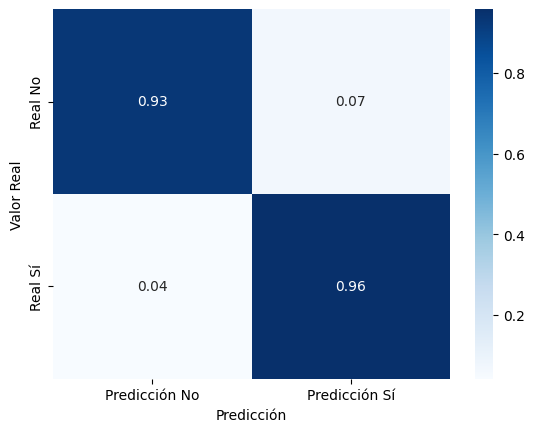

In [11]:
# 1. Confusion Matrix

total_fila_0 = metrics_sis["TN"] + metrics_sis["FP"]
total_fila_1 = metrics_sis["FN"] + metrics_sis["TP"]


conf_parameters = [
    [(metrics_sis["TN"]/total_fila_0), (metrics_sis["FP"]/total_fila_0)],
    [(metrics_sis["FN"]/total_fila_1), (metrics_sis["TP"]/total_fila_1)]
]
sns.heatmap(conf_parameters, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Predicción No", "Predicción Sí"], yticklabels=["Real No", "Real Sí"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


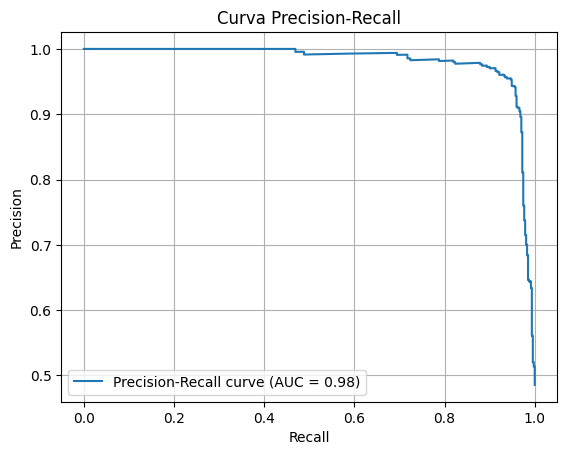

In [36]:
# 2. Precisision vs Recall Curve

precision, recall, _ = precision_recall_curve(ground_truth_sis, conf_to_drone_sis)
auc_value = average_precision_score(ground_truth_sis, conf_to_drone_sis)

plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_value:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.legend(loc="lower left")

plt.show()


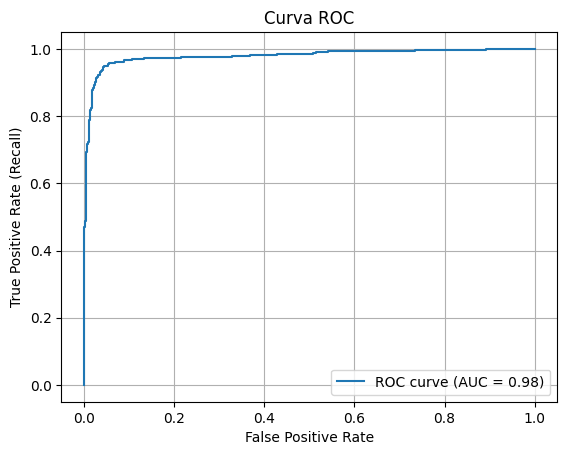

In [32]:
# 3. ROC Curve

fpr, tpr, _ = roc_curve(ground_truth_sis, conf_to_drone_sis)
auc_value = roc_auc_score(ground_truth_sis, conf_to_drone_sis)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC')
plt.grid(True)
plt.legend(loc="lower right")

plt.show()

### Test 2. Gráficas de los resultados

1. Matriz de confusión
2. Curva precisión vs recall
3. Curva ROC


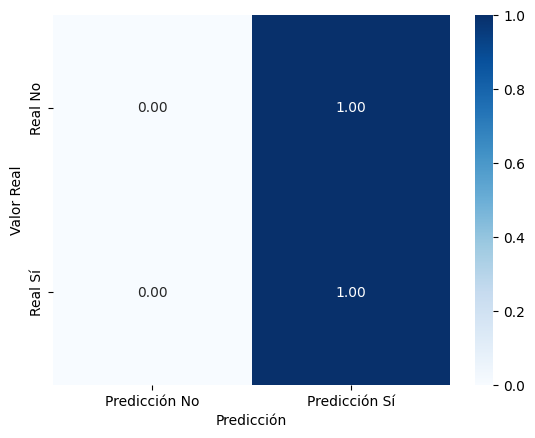

In [18]:
# MATRIZ DE CONFUSIÓN

total_fila_0 = metrics_solo["TN"] + metrics_solo["FP"]
total_fila_1 = metrics_solo["FN"] + metrics_solo["TP"]


conf_parameters_s = [
    [(metrics_solo["TN"]/total_fila_0), (metrics_solo["FP"]/total_fila_0)],
    [(metrics_solo["FN"]/total_fila_1), (metrics_solo["TP"]/total_fila_1)]
]
sns.heatmap(conf_parameters_s, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Predicción No", "Predicción Sí"], yticklabels=["Real No", "Real Sí"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.show()


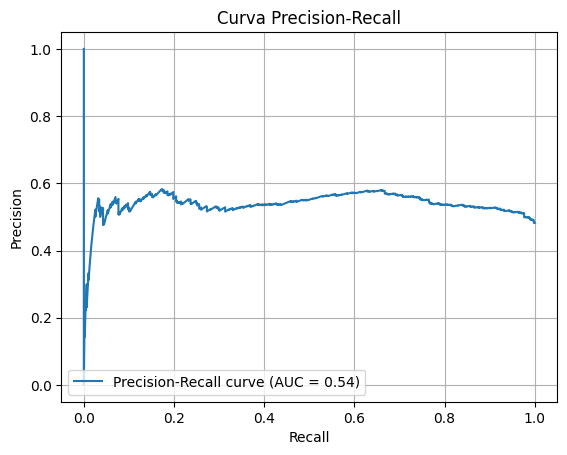

In [37]:
# 2. Precisision vs Recall Curve

precision, recall, _ = precision_recall_curve(ground_truth_solo, conf_to_drone_solo)
auc_value = average_precision_score(ground_truth_solo, conf_to_drone_solo)

plt.plot(recall, precision, label=f'Precision-Recall curve (AUC = {auc_value:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.grid(True)
plt.legend(loc="lower left")

plt.show()

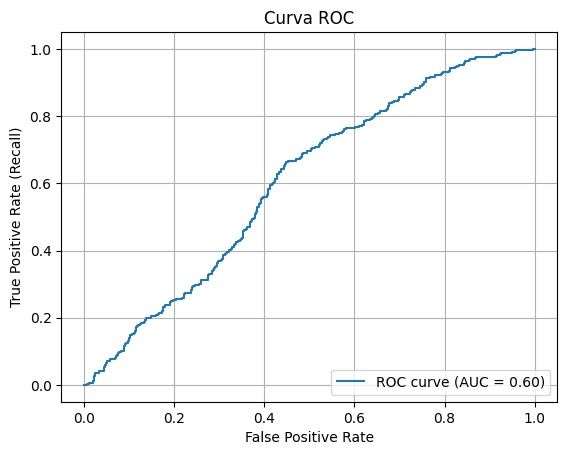

In [31]:
# 3. ROC Curve

fpr, tpr, _ = roc_curve(ground_truth_solo, conf_to_drone_solo)
auc_value = roc_auc_score(ground_truth_solo, conf_to_drone_solo)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_value:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC')
plt.grid(True)
plt.legend(loc="lower right")

plt.show()

### Comparacion de los resultados.

Se mostraran en este apartado las gráficas comparativas de los resultados

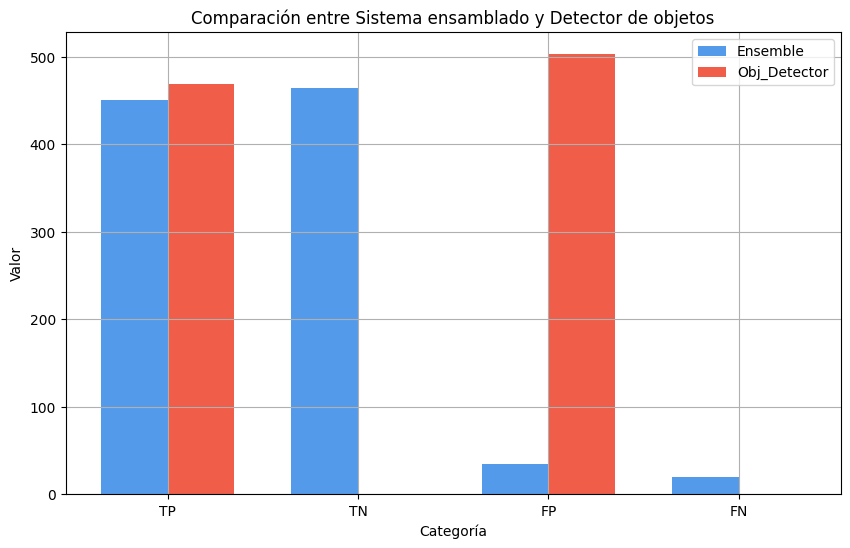

In [38]:
import matplotlib.pyplot as plt
import numpy as np


resultados_ensemble = metrics_sis
resultados_od = metrics_solo

calculo_ensemble = metricas_definitivas_sis
calculo_od = metricas_definitivas_solo


categorias = ['TP', 'TN', 'FP', 'FN']
valores_ensemble = [resultados_ensemble[cat] for cat in categorias]
valores_od = [resultados_od[cat] for cat in categorias]

# Comparación de métricas calculadas
metricas = ['precision', 'recall', 'accuracy', 'f1']
valores_ensemble_calc = [calculo_ensemble[met] for met in metricas]
valores_od_calc = [calculo_od[met] for met in metricas]

# Gráfico de barras para TP, TN, FP, FN
x = np.arange(len(categorias))  
ancho = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x - ancho/2, valores_ensemble, ancho, label='Ensemble', color='#539aea')
plt.bar(x + ancho/2, valores_od, ancho, label='Obj_Detector', color='#f05d49')

plt.xlabel('Categoría')
plt.ylabel('Valor')
plt.title('Comparación entre Sistema ensamblado y Detector de objetos')
plt.xticks(x, categorias)
plt.legend()
plt.grid(True)

plt.show()

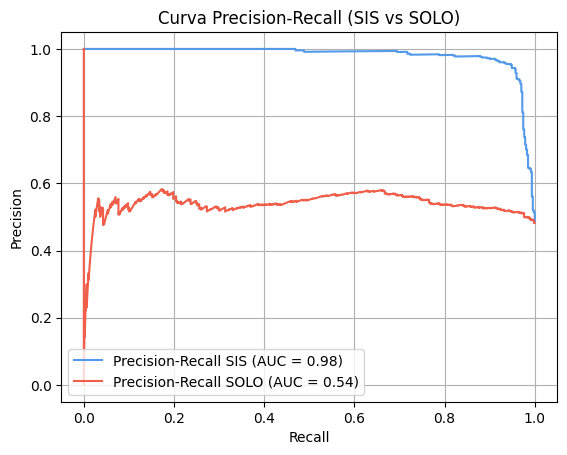

<Figure size 1000x600 with 0 Axes>

In [19]:
# Datos del primer conjunto
precision_sis, recall_sis, _ = precision_recall_curve(ground_truth_sis, conf_to_drone_sis)
auc_sis = average_precision_score(ground_truth_sis, conf_to_drone_sis)

# Datos del segundo conjunto
precision_solo, recall_solo, _ = precision_recall_curve(ground_truth_solo, conf_to_drone_solo)
auc_solo = average_precision_score(ground_truth_solo, conf_to_drone_solo)

# Crear la gráfica combinada
plt.plot(recall_sis, precision_sis, label=f'Precision-Recall SIS (AUC = {auc_sis:.2f})', color='#539aea')
plt.plot(recall_solo, precision_solo, label=f'Precision-Recall SOLO (AUC = {auc_solo:.2f})', color='#f05d49')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (SIS vs SOLO)')
plt.grid(True)
plt.legend(loc="lower left")
plt.figure(figsize=(10, 6))

plt.show()


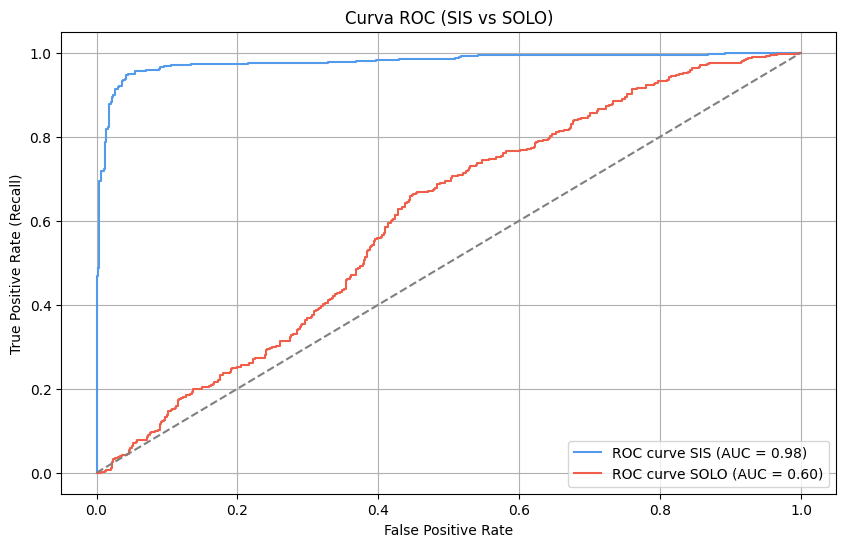

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Datos del primer conjunto
fpr_sis, tpr_sis, _ = roc_curve(ground_truth_sis, conf_to_drone_sis)
auc_sis = roc_auc_score(ground_truth_sis, conf_to_drone_sis)

# Datos del segundo conjunto
fpr_solo, tpr_solo, _ = roc_curve(ground_truth_solo, conf_to_drone_solo)
auc_solo = roc_auc_score(ground_truth_solo, conf_to_drone_solo)


plt.figure(figsize=(10, 6))

plt.plot(fpr_sis, tpr_sis, label=f'ROC curve SIS (AUC = {auc_sis:.2f})', color='#539aea')
plt.plot(fpr_solo, tpr_solo, label=f'ROC curve SOLO (AUC = {auc_solo:.2f})', color='#f05d49')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC (SIS vs SOLO)')
plt.grid(True)
plt.legend(loc="lower right")

plt.show()
